In [1]:
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
import torchaudio
import random
from itertools import combinations
from IPython.display import HTML, Audio
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [2]:
device="cuda"
dataset = datasets.load_dataset("danjacobellis/commonvoice17_en_24kbps").cast_column('opus',datasets.Audio(decode=False))

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/31 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
config.F = 512
config.latent_dim = 8;
config.input_channels = 1
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 8
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 6
config.batch_size = 16
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.epochs = 20
config.progressive_sizes = [config.F*int(s) for s in 2**(np.linspace(6.5,8.9,config.epochs))];
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = False
print(config.progressive_sizes[0]/48000,config.progressive_sizes[-1]/48000)

0.96 5.088


In [4]:
model = AutoCodecND(
    dim=1,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

34.079304 M parameters


In [5]:
def crop_1d(x, ℓ, batch=False):
    if not batch:
        x = x.unsqueeze(0)
    if x.shape[-1]<ℓ:
        r = 2 + (ℓ - x.shape[-1])//x.shape[-1]
        x = x.repeat(1, 1, r)
    x = RandomCrop((1,ℓ))(x.unsqueeze(1))[:,0]
    if not batch:
        x = x[0]
    return x

def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]

C = config.input_channels
def collate_fn(batch, i_epoch):
    L = get_epoch_size(i_epoch)
    B = len(batch)
    x = torch.zeros((B, C, L), dtype=torch.float)
    for i_sample, sample in enumerate(batch):
        xi, fs = torchaudio.load(sample[f'opus']['bytes'], normalize=False)
        xi = crop_1d(xi, L).to(torch.float)
        xi = xi - xi.mean()
        max_abs = xi.abs().max()
        xi = xi / (max_abs + 1e-8)
        x[i_sample,:,:] = xi
    return x

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []

global_step = 0
model.train()
for i_epoch in mb:
    #-----Train-----
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        if i_epoch/config.epochs <= config.freeze_encoder_after :
            # Soft quantization with additive noise
            x_hat, rate = model(x)
        else:
            # Hard quantization
            with torch.no_grad():
                z = model.quantize.compand(model.encode(x))
                z_quant = z.round()
            rate = z.std().log2()              
            x_hat = model.decode(z_quant)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    torch.save({
        'config': config,
        'state_dict': model.state_dict()
    }, 'checkpoint.pth')

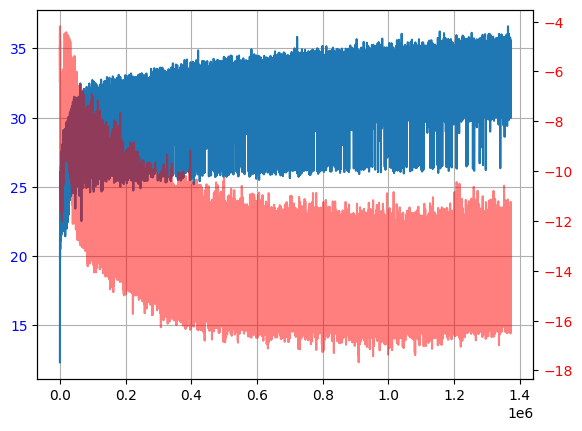

In [7]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [8]:
torch.save({
    'config': config,
    'state_dict': model.state_dict()
}, '../../hf/dance/cv_f512c8.pth')

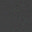

170.00259403372243 compression ratio
64.0× dimension reduction
36.81872369766235 dB PSNR


In [106]:
def valid_collate_fn(batch, i_epoch):
    L = 262144
    B = len(batch)
    x = torch.zeros((B, C, L), dtype=torch.float)
    for i_sample, sample in enumerate(batch):
        xi, fs = torchaudio.load(sample[f'opus']['bytes'], normalize=False)
        xi = crop_1d(xi, L).to(torch.float)
        xi = xi - xi.mean()
        max_abs = xi.abs().max()
        xi = xi / (max_abs + 1e-8)
        x[i_sample,:,:] = xi
    return x
    
x = valid_collate_fn(dataset['validation'].select([6]),6).to(device)
model.eval()
with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round().cpu()
    latent_reshaped = einops.rearrange(latent, 'b (t c) (h w) -> b c (t h) w', t=2, h=16)
    latent_img = latent_to_pil(latent_reshaped, n_bits=8, C=4)
    display(latent_img[0])
    buff = io.BytesIO()
    latent_img[0].save(buff, format='TIFF', compression='tiff_adobe_deflate')
    tiff_bytes = buff.getbuffer()
    print(f"{x.numel()/len(tiff_bytes)} compression ratio")
    print(f"{x.numel()/z.numel()}× dimension reduction")
    latent_decoded = pil_to_latent([PIL.Image.open(buff)], N=4, n_bits=8, C=4)
    latent_decoded = einops.rearrange(latent_decoded, 'b c (t h) w -> b (t c) (h w)', t=2)
    x_hat = model.decode(latent_decoded.to(device))
    x_hat = x_hat.clamp(-1,1)
mse = torch.nn.functional.mse_loss(x,x_hat)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")

In [107]:
from IPython.display import Audio as play
display(play(x[0,:].cpu(),rate=48000))
display(play(x_hat[0,:].cpu(),rate=48000))

(-4.0, 4.0)

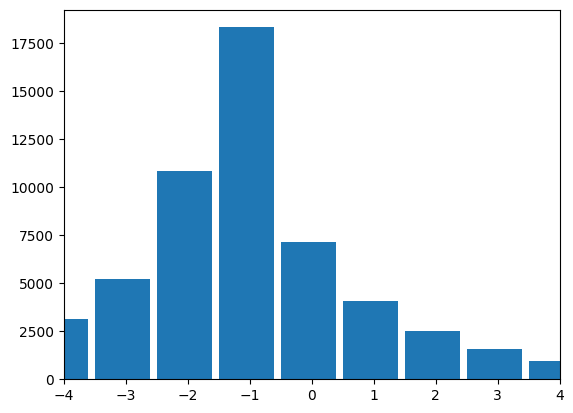

In [108]:
plt.hist(z_quant.flatten().cpu().numpy(),range=(-127.5,127.5),bins=255,width=0.9);
plt.xlim([-4,4])